## Homework 1-2: Introduction to Webscraping with BeautifulSoup 



Sometimes the most interesting data sets don’t come with an API or pre-packaged <font color=orange>plain-text</font> (纯文本) CSVs. In these situations, web scraping can be a powerful tool, enabling us to extract and convert data from almost any format found on the internet into a <font color=orange>tabular form</font> (表格形式) we can conduct further analysis on. 

For this section we will be working with <font color=orange>historic population estimates</font> (历史人口估计) of different US states listed on Wikipedia here:https://en.wikipedia.org/wiki/List_of_U.S._states_by_historical_population. In this section, you’ll learn <font color=red>how to import html-tables on the web into something you can manipulate with pandas. </font>

Specifically, we will: 
    
* Download the relevant webpage as raw html with the **requests library**  
* Parse the html into a **tree-like python-object** with the BeautifulSoup library
* Use BeautifulSoup to **select** and **extract** just the tables we’re interested in
* Combine the tables, clean the text, and convert them into a single **python dictionary** 
* Make a pandas dataframe from the dictionary 
* Doing some basic **analysis** and **plotting** (with matplotlib) 

As usual, our first step is to import the necessary libraries.

## step 0: 实验前的准备

In [1]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

# Two new 
import requests 
requests.packages.urllib3.disable_warnings()
#Requests enables us to download raw html as text
from bs4 import BeautifulSoup 
# BeautifulSoup enables us to navigate html in python with dom-like tree structure 

In [2]:
import sys
sys.executable

'/opt/anaconda3/envs/ML_EXP/bin/python'

In [3]:
# import matplotlib
# # matplotlib.use('qt4agg')
# #指定默认字体
# matplotlib.rcParams['font.sans-serif'] = ['SimHei']
# matplotlib.rcParams['font.family']='sans-serif'
# #解决负号'-'显示为方块的问题
# matplotlib.rcParams['axes.unicode_minus'] = False

## Step 1: Download the relevant webpage as raw html

In [4]:
#url = "http://www.baidu.com"
url="https://en.wikipedia.org/wiki/List_of_U.S._states_by_historical_population"

r = requests.get(url, timeout=60,verify=False)

Always remember to “<font color=red>not to be evil</font>” when scraping with requests! 

If downloading multiple pages, always put a delay between requests (e.g,, time.sleep(1), with the time library) 

so you don’t unwittingly hammer someone’s webserver and/or get blocked.

In [5]:
raw_html = r.text
raw_html
print(raw_html)

<!DOCTYPE html>
<html class="client-nojs" lang="en" dir="ltr">
<head>
<meta charset="UTF-8"/>
<title>List of U.S. states and territories by historical population - Wikipedia</title>
<script>document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"4a76ce63-2fab-4aca-98d7-4758756c9235","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_U.S._states_and_territories_by_historical_population","wgTitle":"List of U.S. states and territories by historical population","wgCurRevisionId":1048950568,"wgRevisionId":1048950568,"wgArticleId":30259061,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Articles with short descr

Now, we have all our data in the notebook. 

Unfortunately, <font color=blue>it is the form of one really long string</font>, which <font color=red>is hard to work with directly.</font> 

This is where BeautifulSoup comes in.  

## Step 2: Parse the html with BeautifulSoup

In [6]:
soup = BeautifulSoup(raw_html, 'html.parser')

Key BeautifulSoup functions we’ll be using in this section:
- **soup.prettify()**: Returns cleanedup version of raw html for printing
- **soup.find_all(<htmltag>,attrs=<attributes>)**: Returns python list of matching objects
- **soup.find(<htmltag>,attrs=<attributes>)**: Returns first matching object 
- **soup.text/soup.get_text()**: Returns visible text of an object (e.g.,"`<p>Some text</p>`" -> "Some text")
    
BeautifulSoup is a very powerful library -- much more info here: https://www.crummy.com/software/BeautifulSoup/bs4/doc/

### Let's practice some BeautifulSoup commands.. 

**Print a cleanedup version of raw html for printing**

In [7]:
# 输出一个 cleanedup 版本的 raw HTML
soup.prettify()

'<!DOCTYPE html>\n<html class="client-nojs" dir="ltr" lang="en">\n <head>\n  <meta charset="utf-8"/>\n  <title>\n   List of U.S. states and territories by historical population - Wikipedia\n  </title>\n  <script>\n   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"4a76ce63-2fab-4aca-98d7-4758756c9235","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_U.S._states_and_territories_by_historical_population","wgTitle":"List of U.S. states and territories by historical population","wgCurRevisionId":1048950568,"wgRevisionId":1048950568,"wgArticleId":30259061,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":

**Find the first “title” object** 

In [8]:
# 找到第一个 title object
soup.find("title") 

<title>List of U.S. states and territories by historical population - Wikipedia</title>

**Find the text of first “title” object** 

In [9]:
# 找到 text 中的第一个 title
soup.find("title").get_text("title")  # 通过参数指定 tag 的文本内容的分隔符

'List of U.S. states and territories by historical population - Wikipedia'

## Step 3: extract just the tables we’re interested in 

In [10]:
tables = soup.find_all("table",attrs={"class":"wikitable"})
# This says return a list of all table objects that include 
# the css class “wikitable” within the soup object.  
len(tables)

7

As it turns out, the data we’re interested in is in the 1st, 3rd, and 4th wikitable table on the page. 

In [11]:
tables = [tables[0], tables[2], tables[3]]
len(tables)

3

## Step 4: Convert the html tables into a python dictionary 

Before we can think about how to extract what we need, we need to understand how tables are constructed in HTML...

In [12]:
from IPython.core.display import display, HTML
display(HTML("""<table>
  <tr>
    <th>Firstname</th>
    <th>Lastname</th> 
    <th>Age</th>
  </tr>
  <tr>
    <td>Jill</td>
    <td>Smith</td> 
    <td>50</td>
  </tr>
  <tr>
    <td>Eve</td>
    <td>Jackson</td> 
    <td>94</td>
  </tr>
</table>"""))

Firstname,Lastname,Age
Jill,Smith,50
Eve,Jackson,94


Now let’s look at the first table in the list of tables we’re trying to import.

In [13]:
# Let's render the first table as HTML
from IPython.core.display import display, HTML
display(HTML(tables[0].prettify()))

Name,Admitted [d],1790,1800,1810,1820,1830,1840,1850,1860
Alabama,1819,,"1,250","9,046","127,901","309,527","590,756","771,623","964,201"
Alaska,1959,,,,,,,,
American Samoa,1900,,,,,,,,
Arizona,1912,,,,,,,,
Arkansas,1836,,,"1,062","14,273","30,388","97,574","209,897","435,450"
California,1850,,,,,,,"92,597","379,994"
Colorado,1876,,,,,,,,"34,277"
Connecticut,1788,"237,946","251,002","262,042","275,202","297,675","309,978","370,792","460,147"
Delaware,1787,"59,096","64,273","72,674","72,749","76,748","78,085","91,532","112,216"
"<img alt="""" class=""thumbborder"" data-file-height=""400"" data-file-width=""800"" decoding=""async"" height=""12"" src=""//upload.wikimedia.org/wikipedia/commons/thumb/d/d4/Flag_of_the_District_of_Columbia.svg/23px-Flag_of_the_District_of_Columbia.svg.png"" srcset=""//upload.wikimedia.org/wikipedia/commons/thumb/d/d4/Flag_of_the_District_of_Columbia.svg/35px-Flag_of_the_District_of_Columbia.svg.png 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/d/d4/Flag_of_the_District_of_Columbia.svg/46px-Flag_of_the_District_of_Columbia.svg.png 2x"" width=""23""/> District of Columbia [e]",1790,,"8,144","15,471","23,336","30,261","33,745","51,687","75,080"


Our goal is to <font color=orange>associate a series of population values with each state</font> (将一系列人口值与每个州相关联), so that we can build a **time series table** across all three tables. 

Things to keep in mind while building our extract routine:

    - We don’t care about the “admitted” column (我们不关注「admitted」列)
    - We want to remove the commas (逗号) from the numbers so python interprets them as ints rather than strings (我们想从数字中删除逗号，以便 python 将它们解释为整数而不是字符串)
    - We want to remove the footnotes and links (我们要删除脚注和链接) 

Now, let’s try to extract out our data…

In [14]:
def rm_footnotes(s):
    """
        Removes any text after first '[' in string
        District of Columbia[1] -> District of Columbia
    """
    # 一直遍历, 删除 []
    while "[" in s:
        x_start = s.index("[")
        x_end = s.index("]") + len("]") # s.index()函数算出来的是字符串的最左边的第一个位置

        x_all = s[x_start : x_end]
        result = s.replace(x_all, "")
        s =result
        
    return s
    
    
def clean_int(s):
    """
        Removes any commas or footnotes from string and converts to int.
        Returns zero for blank strings
    """
    # 消除 , \n 和 []
    s = s.replace(",", "")
    s = rm_footnotes(s)
    s = s.replace("\n", "")
    
    if s =="" or s =="\xa0":
        s = '0'
    
    return s

In [15]:
d = dict()

for table in tables:
    """
        Extracts population data for states from all tables in tables 
        and store it in single dictionary d 
    """
    
    headrow = table.find("tr")

    # bug !!!!!!
    col_names = [(idx,th.text.replace('\n','')) for idx,th in enumerate(headrow.find_all('th')) if th.text.replace('\n','').isnumeric()]
    # Makes list of tuples like this with idx and name for cols with years.
    # By using isnumeric, we only include columns are that are years. 
    # Result looks like this: 
    # [(2, '1790'), (3, '1800'), (4, '1810')]                     
    
    rows = table.find_all("tr")[1:]
    # List of rows in table excluding the header row 
    
    for row in rows:

        # 没问题
        state_name = rm_footnotes(row.find('td').text.replace("\n", "").replace("\xa0", ""))
        # String of state name, with any footnotes removed 
        
        # 没问题
        all_cells = [c.text for c in row.find_all('td')]
        # List of cell values for row, e.g.: 
        # ['Alabama', '1819', '\xa0', '1,250', '9,046' .. ] 
        
        existing_values = d.get(state_name,{})
        # Existing dict of values for given state 
        
        new_values = {year:clean_int(all_cells[idx]) for (idx,year) in col_names}
        # For cols listed in col_names, return dict of cleaned int values 
        # {'1790': 0, '1800': 1250, '1810': 9046...}


        
        existing_values.update(new_values)
        # Merge with existing dict for state 
        d[state_name] = existing_values
d

{'Alabama': {'1790': '0',
  '1800': '1250',
  '1810': '9046',
  '1820': '127901',
  '1830': '309527',
  '1840': '590756',
  '1850': '771623',
  '1860': '964201',
  '1870': '996992',
  '1880': '1262505',
  '1900': '1828697',
  '1910': '2138093',
  '1920': '2348174',
  '1930': '2646248',
  '1940': '2832961',
  '1950': '3061743',
  '1960': '3266740',
  '1970': '3444165',
  '1980': '3893888',
  '1990': '4040587',
  '2000': '4447100',
  '2010': '4779736',
  '2020': '5024279'},
 'Alaska': {'1790': '0',
  '1800': '0',
  '1810': '0',
  '1820': '0',
  '1830': '0',
  '1840': '0',
  '1850': '0',
  '1860': '0',
  '1870': '0',
  '1880': '33426',
  '1900': '63592',
  '1910': '64356',
  '1920': '55036',
  '1930': '59278',
  '1940': '72524',
  '1950': '128643',
  '1960': '226167',
  '1970': '300382',
  '1980': '401851',
  '1990': '550043',
  '2000': '626932',
  '2010': '710231',
  '2020': '733391'},
 'American Samoa': {'1790': '0',
  '1800': '0',
  '1810': '0',
  '1820': '0',
  '1830': '0',
  '1840': 

## Step 5: Make a pandas dataframe from the dictionary 

Now that we have all three tables in a **cleaned dictionary form**, with each state as a key, and time series for each sate (as another dict) as it’s value, it's simple to convert to a pandas DataFrame.

In [16]:
df = pd.DataFrame.from_dict(d,orient='index')
df
# 出现 NaN 值是因为有缺省值

,1790,1800,1810,1820,1830,1840,1850,1860,1870,1880,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010,2020
Alabama,0,1250,9046,127901,309527,590756,771623,964201,996992,1262505,1828697,2138093,2348174,2646248,2832961,3061743,3266740,3444165,3893888,4040587,4447100,4779736,5024279
Alaska,0,0,0,0,0,0,0,0,0,33426,63592,64356,55036,59278,72524,128643,226167,300382,401851,550043,626932,710231,733391
American Samoa,0,0,0,0,0,0,0,0,0,0,0,0,8056,10055,12908,24889,20051,27159,32297,46773,57291,55519,0
Arizona,0,0,0,0,0,0,0,0,9658,40440,122931,204354,334162,435573,499261,749587,1302161,1770900,2718215,3665228,5130632,6392017,7151502
Arkansas,0,0,1062,14273,30388,97574,209897,435450,484471,802525,1311564,1574449,1752204,1854482,1949387,1909511,1786272,1923295,2286435,2350725,2673400,2915918,3011524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vermont,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,330551,332286,343641,355956,352428,359611,359231,377747,389881,444330,511456,562758,608827,625741,643077
Virginia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1225163,1512565,1854184,2061612,2309187,2421851,2677773,3318680,3966949,4648494,5346818,6187358,7078515,8001024,8631393
Washington,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23955,75116,518103,1141990,1356621,1563396,1736191,2378963,2853214,3409169,4132156,4866692,5894121,6724540,7705281
West Virginia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,442014,618457,958800,1221119,1463701,1729205,1901974,2005552,1860421,1744237,1949644,1793477,1808344,1852994,1793716


This looks pretty good! However, we’ve accidently imported the total row (United States). We could address that in our function above, or just drop it from our dataframe.  

In [17]:
df = df.drop(["United States"])  
df 

,1790,1800,1810,1820,1830,1840,1850,1860,1870,1880,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010,2020
Alabama,0,1250,9046,127901,309527,590756,771623,964201,996992,1262505,1828697,2138093,2348174,2646248,2832961,3061743,3266740,3444165,3893888,4040587,4447100,4779736,5024279
Alaska,0,0,0,0,0,0,0,0,0,33426,63592,64356,55036,59278,72524,128643,226167,300382,401851,550043,626932,710231,733391
American Samoa,0,0,0,0,0,0,0,0,0,0,0,0,8056,10055,12908,24889,20051,27159,32297,46773,57291,55519,0
Arizona,0,0,0,0,0,0,0,0,9658,40440,122931,204354,334162,435573,499261,749587,1302161,1770900,2718215,3665228,5130632,6392017,7151502
Arkansas,0,0,1062,14273,30388,97574,209897,435450,484471,802525,1311564,1574449,1752204,1854482,1949387,1909511,1786272,1923295,2286435,2350725,2673400,2915918,3011524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vermont,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,330551,332286,343641,355956,352428,359611,359231,377747,389881,444330,511456,562758,608827,625741,643077
Virginia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1225163,1512565,1854184,2061612,2309187,2421851,2677773,3318680,3966949,4648494,5346818,6187358,7078515,8001024,8631393
Washington,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23955,75116,518103,1141990,1356621,1563396,1736191,2378963,2853214,3409169,4132156,4866692,5894121,6724540,7705281
West Virginia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,442014,618457,958800,1221119,1463701,1729205,1901974,2005552,1860421,1744237,1949644,1793477,1808344,1852994,1793716


In [18]:
df = df.astype(float)

## An alternative aproach -- Using pd.read_html() instead

In this particular situation, using Panda’s built-in “read_html” function actually works pretty well, and would have saved us a lot of code above. 

However, <font color=red>not all datasets come in nicely formatted html tables</font>, so it’s important to develop the skills to write a scraping routine from scratch from any type of html page (as we did above)

More info here: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_html.html 

In [19]:
# pd.read_html(tables[0].prettify(),header=0, index_col=0)[0]

(Note – if we really wanted to take this approach, we’d have to handle removing the footnotes and merging/joining the tables in Pandas.)

## Step 6: let's plot our data!

In [20]:
# 设置图片显示的字体大小
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size' : 18,}

font2 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size' : 30,}

Text(0.5, 1.0, 'US Population by State, 1790-2010 \n')

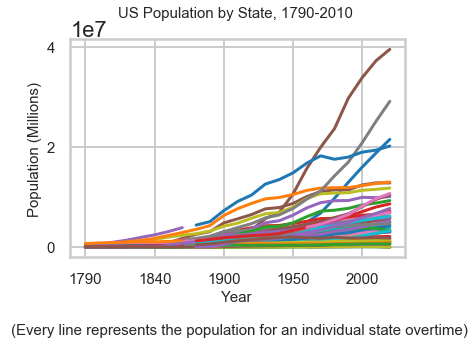

In [21]:
df.T.plot(legend=None, fontsize=15) 
plt.ylabel("Population (Millions)", fontsize=15)
plt.xlabel('Year \n\n (Every line represents the population for an individual state overtime)', fontsize=15)
plt.title("US Population by State, 1790-2010 \n", fontsize=15)

Text(0.5, 0, 'Year \n\n (Every line represents the population for an individual state overtime)')

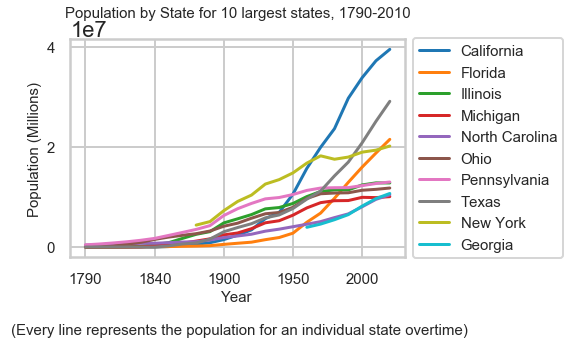

In [22]:
# let's look at just the 10 largest states (2010 population)
df.sort_values('2010', ascending=False)
largest = df['2010'].nlargest(10).index
df[df.index.isin(largest)].T.plot(fontsize=15)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=15)
plt.title("Population by State for 10 largest states, 1790-2010\n", fontsize=15)
plt.ylabel("Population (Millions)", fontsize=15)
plt.xlabel('Year \n\n (Every line represents the population for an individual state overtime)', fontsize=15)

Perhaps it will be more interested to view as percentage of total US population, so we can see relative change overtime…

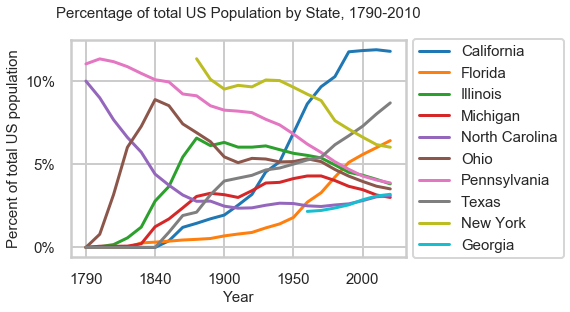

In [23]:
import matplotlib.ticker as mtick
cols = df.columns
by_percent = df[cols].div(df[cols].sum(axis=0), axis=1).multiply(100)
by_percent[by_percent.index.isin(largest)].T.plot(fontsize=15)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=15)
plt.ylabel("Percent of total US population", fontsize=15)
plt.xlabel("Year", fontsize=15)
plt.title("Percentage of total US Population by State, 1790-2010\n", fontsize=15)

# Make y-axis percentages 
ax = plt.gca()
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)

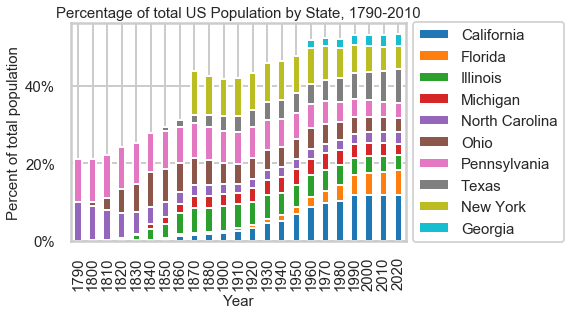

In [24]:
by_percent[by_percent.index.isin(largest)].T.plot(kind="bar",stacked=True, fontsize=15)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=15)
plt.ylabel("Percent of total population", fontsize=15)
plt.xlabel("Year", fontsize=15)
plt.title("Percentage of total US Population by State, 1790-2010", fontsize=15)

ax = plt.gca()
ax.yaxis.set_major_formatter(yticks)